<a href="https://colab.research.google.com/github/duybluemind1988/Data-science/blob/master/Anomaly/Abnomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import numpy as np
import pandas as pd
from sklearn import preprocessing,decomposition,model_selection
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [5]:
file='https://media.githubusercontent.com/media/aapatel09/handson-unsupervised-learning/master/datasets/credit_card_data/credit_card.csv'
df = pd.read_csv(file)

In [17]:
print(df.shape)
df.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [19]:
def show_pca_df(df):
	x = df[df.columns[1:30]].to_numpy()
	y = df[df.columns[30]].to_numpy()

	x = preprocessing.MinMaxScaler().fit_transform(x)
	pca = decomposition.PCA(n_components=3)
	pca_result = pca.fit_transform(x)
	print(pca.explained_variance_ratio_)

	pca_df = pd.DataFrame(data=pca_result, columns=['pc_1', 'pc_2', 'pc_3'])
	pca_df = pd.concat([pca_df, pd.DataFrame({'label': y})], axis=1)

	ax = Axes3D(plt.figure(figsize=(8, 8)))
	ax.scatter(xs=pca_df['pc_1'], ys=pca_df['pc_2'], zs=pca_df['pc_3'], c=pca_df['label'], s=25)
	ax.set_xlabel("pc_1")
	ax.set_ylabel("pc_2")
	ax.set_zlabel("pc_3")
	plt.show()

In [11]:
x = df[data.columns[1:30]].to_numpy() # remove Time column
y = df[data.columns[30]].to_numpy()

x = preprocessing.MinMaxScaler().fit_transform(x) # nomalize before dimension reduction
pca = decomposition.PCA(n_components=3)
pca_result = pca.fit_transform(x)
print(pca.explained_variance_ratio_)

[0.13501016 0.12577772 0.12031404]


In [12]:
pca_df = pd.DataFrame(data=pca_result, columns=['pc_1', 'pc_2', 'pc_3'])
pca_df = pd.concat([pca_df, pd.DataFrame({'label': y})], axis=1)
pca_df

,pc_1,pc_2,pc_3,label
0,0.009017,-0.030865,-0.076738,0
1,-0.045796,0.020564,0.037857,0
2,-0.092875,-0.022686,0.055537,0
3,-0.158409,-0.036206,0.039307,0
4,0.019030,0.082073,0.104179,0
...,...,...,...,...
284802,-0.068618,0.040828,-0.053367,0
284803,-0.136941,-0.064550,0.094032,0
284804,0.086261,-0.014273,-0.014220,0
284805,0.016598,0.089289,-0.080666,0


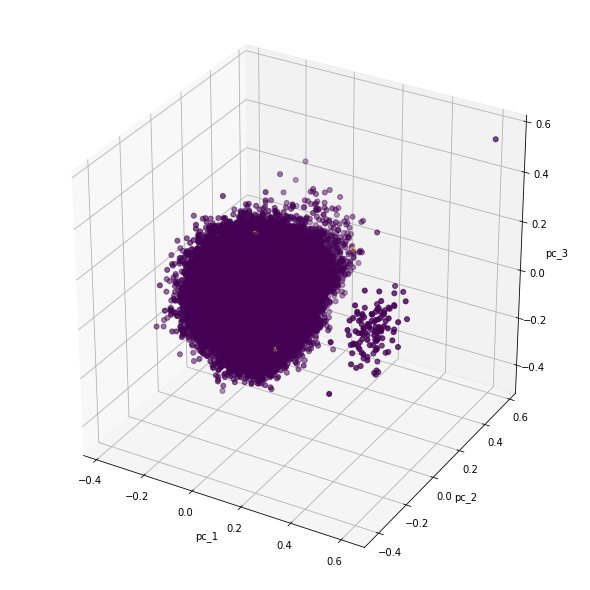

In [15]:
ax = Axes3D(plt.figure(figsize=(8, 8)))
ax.scatter(xs=pca_df['pc_1'], ys=pca_df['pc_2'], zs=pca_df['pc_3'], c=pca_df['label'], s=25)
ax.set_xlabel("pc_1")
ax.set_ylabel("pc_2")
ax.set_zlabel("pc_3")
plt.show()

Your first reaction could be that there are two clusters and this would be an easy task but fraud data is yellow points! There are three visible yellow points in the large cluster. So let’s subsample the normal data while keeping the number of fraud data.

In [21]:
df_anomaly = df[df[df.columns[30]] ==1]
df_normal = df[df[df.columns[30]] == 0].sample(n=df_anomaly.size, random_state=1, axis='index')
df = pd.concat([ df_anomaly, df_normal])
print(df_anomaly.size)
print(df_anomaly.shape,df_normal.shape,df.shape)

15252
(492, 31) (15252, 31) (15744, 31)


[0.20577961 0.14728955 0.09800457]


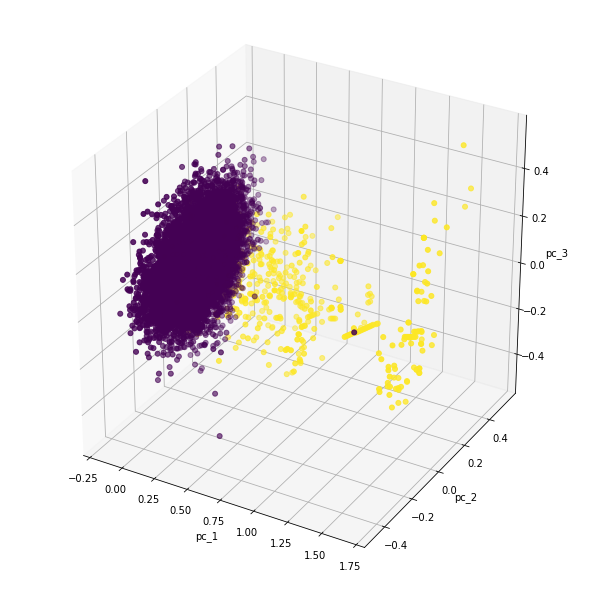

In [20]:
show_pca_df(df)

Now it is visible that normal transactions are clustered in a disk while frauded transactions are more distributed.

We are going to build an autoencoder with 3 layer encoder and 2 layer decoder:

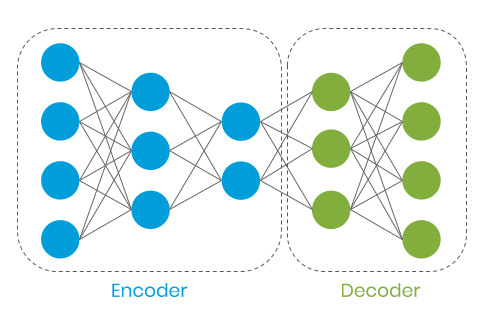

The Autoencoder will encode our data into a subspace and decode the feature back while normalizing the data. Our expectation is autoencoder will learn the features of normal transactions and the input will be similar to output when applied. For anomalies, the input and the output will be significantly different since it is unexpected data.

The good part of this approach is it allows us to use unsupervised learning and we usually have plenty of normal transaction data. Data labeling is usually expensive, hard, and in some cases unavailable. Manual data labeling also includes human interaction which causes human biased implementations. It can be seen that in the model training we only use normal transaction features and not the labels.

Let’s load data and train our autoencoder:

In [22]:
file='https://media.githubusercontent.com/media/aapatel09/handson-unsupervised-learning/master/datasets/credit_card_data/credit_card.csv'
df = pd.read_csv(file)

In [23]:
x = df[df.columns[1:30]].to_numpy()
y = df[df.columns[30]].to_numpy()

# prepare data
df = pd.concat([pd.DataFrame(x), pd.DataFrame({'anomaly': y})], axis=1)
normal_events = df[df['anomaly'] == 0]
abnormal_events = df[df['anomaly'] == 1]

In [25]:
print(df.shape,normal_events.shape,abnormal_events.shape)

(284807, 30) (284315, 30) (492, 30)


In [26]:
# Remove target column 
normal_events = normal_events.loc[:, normal_events.columns != 'anomaly']
abnormal_events = abnormal_events.loc[:, abnormal_events.columns != 'anomaly']

In [30]:
# scaling
scaler = preprocessing.StandardScaler()
normal_events_scaler = scaler.fit_transform(normal_events)

In [32]:
# 80% percent of dataset is designated to training
train_data, test_data = model_selection.train_test_split(normal_events_scaler, test_size=0.2)

In [36]:
n_features = train_data.shape[1]
n_features

29

In [61]:
from keras import models,layers,activations,losses,optimizers,metrics
from keras.callbacks import EarlyStopping

In [43]:
# model
encoder = models.Sequential(name='encoder')
encoder.add(layer=layers.Dense(units=20, activation=activations.relu, input_shape=[n_features]))
encoder.add(layers.Dropout(0.1))
encoder.add(layer=layers.Dense(units=10, activation=activations.relu))
encoder.add(layer=layers.Dense(units=5, activation=activations.relu))

decoder = models.Sequential(name='decoder')
decoder.add(layer=layers.Dense(units=10, activation=activations.relu, input_shape=[5]))
decoder.add(layer=layers.Dense(units=20, activation=activations.relu))
decoder.add(layers.Dropout(0.1))
decoder.add(layer=layers.Dense(units=n_features, activation=activations.sigmoid))

autoencoder = models.Sequential([encoder, decoder])
autoencoder

In [47]:
print(autoencoder.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 5)                 865       
_________________________________________________________________
decoder (Sequential)         (None, 29)                889       
Total params: 1,754
Trainable params: 1,754
Non-trainable params: 0
_________________________________________________________________
None


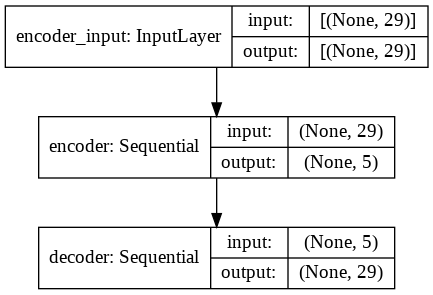

In [49]:
from keras.utils.vis_utils import plot_model
plot_model(autoencoder ,show_shapes=True, show_layer_names=True)

In [57]:
autoencoder.compile(
	loss=losses.MSE,
	optimizer=optimizers.Adam(),
	metrics=[metrics.mean_squared_error])

In [62]:
# train model
es = EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=20, restore_best_weights=True)
history = autoencoder.fit(x=train_data, y=train_data, epochs=100, verbose=1, validation_data=[test_data, test_data], callbacks=[es])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Epoch 1/100
7085/7108 [============================>.] - ETA: 0s - loss: 0.9913 - mean_squared_error: 0.9913

ValueError: ignored

In [ ]:
train_predicted_x = autoencoder.predict(x=train_data)
train_events_mse = losses.mean_squared_error(train_data, train_predicted_x)
cut_off = np.percentile(train_events_mse, 95)

In [ ]:
plot_samples = 100
# normal event
real_x = test_data[:plot_samples].reshape(plot_samples, n_features)
predicted_x = autoencoder.predict(x=real_x)
normal_events_mse = losses.mean_squared_error(real_x, predicted_x)
normal_events_df = pd.DataFrame({
	'mse': normal_events_mse,
	'n': np.arange(0, plot_samples),
	'anomaly': np.zeros(plot_samples)})



# abnormal event
abnormal_x = scaler.transform(abnormal_events)[:plot_samples].reshape(plot_samples, n_features)
predicted_x = autoencoder.predict(x=abnormal_x)
abnormal_events_mse = losses.mean_squared_error(abnormal_x, predicted_x)
abnormal_events_df = pd.DataFrame({
	'mse': abnormal_events_mse,
	'n': np.arange(0, plot_samples),
	'anomaly': np.ones(plot_samples)})

mse_df = pd.concat([normal_events_df, abnormal_events_df])
plot = sns.lineplot(x=mse_df.n, y=mse_df.mse, hue=mse_df.anomaly)

line = lines.Line2D(
	xdata=np.arange(0, plot_samples),
	ydata=np.full(plot_samples, cut_off),
	color='#CC2B5E',
	linewidth=1.5,
	linestyle='dashed')

plot.add_artist(line)
plt.title('Threshlold: {threshold}'.format(threshold=cut_off))
plt.show()